In [48]:
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import numpy as np
import sys
import matplotlib.pyplot as plt 
np.set_printoptions(threshold=sys.maxsize)

In [49]:
csv1 = pd.read_csv('sequence_execution_time.csv')

In [50]:
data = csv1

In [51]:
data = data.drop(csv1.index[5000:])

In [52]:
data.describe()

,execution_time
count,5000.000000
mean,2048.332630
std,4126.782632
min,196.458000
25%,559.416750
50%,676.042000
75%,1448.677750
max,65904.334000


In [53]:
reads = data.drop(['sequence_identifier','quality'], axis =1)
#reads

In [54]:
#Normalize data
reads['execution_time'] = np.log10(reads.execution_time)
#reads

In [55]:
def Kmers_funct(seq, size=3): 
   return [seq[x:x+size].upper() for x in range(len(seq) - size + 1)]

reads['words'] = reads.apply(lambda x: Kmers_funct(x['read_sequence']), axis=1)
reads = reads.drop('read_sequence', axis=1)

In [56]:
reads

,execution_time,words
0,3.360806,"[CTG, TGG, GGT, GTC, TCC, CCT, CTA, TAA, AAC, ..."
1,2.828660,"[TGG, GGC, GCT, CTA, TAT, ATG, TGG, GGG, GGC, ..."
2,2.879216,"[ACT, CTT, TTT, TTC, TCT, CTA, TAT, ATC, TCT, ..."
3,2.598836,"[ATC, TCA, CAA, AAA, AAA, AAA, AAC, ACA, CAT, ..."
4,2.829304,"[CAG, AGG, GGT, GTT, TTC, TCC, CCA, CAA, AAT, ..."
...,...,...
4995,2.845123,"[CAG, AGT, GTG, TGC, GCT, CTA, TAT, ATT, TTC, ..."
4996,2.378472,"[ACC, CCG, CGG, GGC, GCC, CCC, CCG, CGG, GGG, ..."
4997,2.363689,"[TCT, CTG, TGG, GGA, GAC, ACA, CAA, AAG, AGC, ..."
4998,2.896251,"[GAT, ATA, TAA, AAC, ACT, CTG, TGT, GTA, TAT, ..."


In [57]:
human_texts = list(reads['words'])
for item in range(len(human_texts)):
   human_texts[item] = ' '.join(human_texts[item])
#separate labels
y_human = reads.iloc[:, 0].values # y_human for human_dna

In [58]:
# from sklearn.feature_extraction.text import CountVectorizer
# cv = CountVectorizer(ngram_range = (4,4)) # initially (4,4)
# X = cv.fit_transform(human_texts)

from sklearn.feature_extraction.text import TfidfVectorizer
tfid = TfidfVectorizer(ngram_range = (4,4))
X = tfid.fit_transform(human_texts)

In [59]:
Y= y_human

X= X

In [60]:
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score
import math

In [61]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train,y_test = train_test_split(X,Y, test_size = 0.2, random_state = 42)
print('X_train',X_train.shape)
print('X_test',X_test.shape)
print('y_train',y_train.shape)
print('y_test',y_test.shape)

X_train (4000, 4116)
X_test (1000, 4116)
y_train (4000,)
y_test (1000,)


In [62]:
from catboost import  EShapCalcType, EFeaturesSelectionAlgorithm

In [63]:
cat_model = CatBoostRegressor( random_seed = 42) #, early_stopping_rounds = 100, , save_snapshot = True, snapshot_interval = 60, iterations= 10000, early_stopping_rounds = 100, 

In [64]:
# # Fit model and validate
# cat_model.fit( X_train, y_train,
#                eval_set=(X_test, y_test),
#                plot=True,
#               verbose = False
#               )

In [65]:
summary = cat_model.select_features(
                    X = X_train,
                    y = y_train,
                    eval_set=(X_test, y_test),
                    features_for_select='0-4115',
                    num_features_to_select = 1000,
                    steps = 25,
                    algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues,
                    shap_calc_type=EShapCalcType.Regular,
                    train_final_model=True,
                    logging_level='Silent',
                    plot=True
                    
)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [66]:
# feature_importance = pd.DataFrame(cat_model.get_feature_importance(prettified=True))

# plt.figure(figsize=(12, 6));
# feature_plot= sns.barplot(x="Importances", y="Feature Id", data = feature_importance,palette="cool");
# plt.title('feature importance');

In [67]:
y_predict_train = cat_model.predict(X_train)
y_predict= cat_model.predict(X_test)
#RMSE
Rmse_train = math.sqrt(mean_squared_error(y_train,y_predict_train ))
Rmse_test = math.sqrt(mean_squared_error(y_test,y_predict))

#R
r2_train = cat_model.score(X_train,y_train)
r2_test = r2_score(y_test,y_predict)

# Adjusted R2 
n= X_train.shape[0] 
p= X_train.shape[1] 
adj_r2_test = 1-(1-r2_test)*(n-1)/(n-p-1)


print("Evaluation on test data")
print("RMSE train: {:.2f}".format(Rmse_train))
print("RMSE test: {:.2f}".format(Rmse_test))
print("R2 train: {:.2f}".format(r2_train))
print("R2 test: {:.2f}".format(r2_test))
print("Adjusted R2 test: {:.2f}".format(adj_r2_test)) 

Evaluation on test data
RMSE train: 0.20
RMSE test: 0.28
R2 train: 0.80
R2 test: 0.58
Adjusted R2 test: 15.22


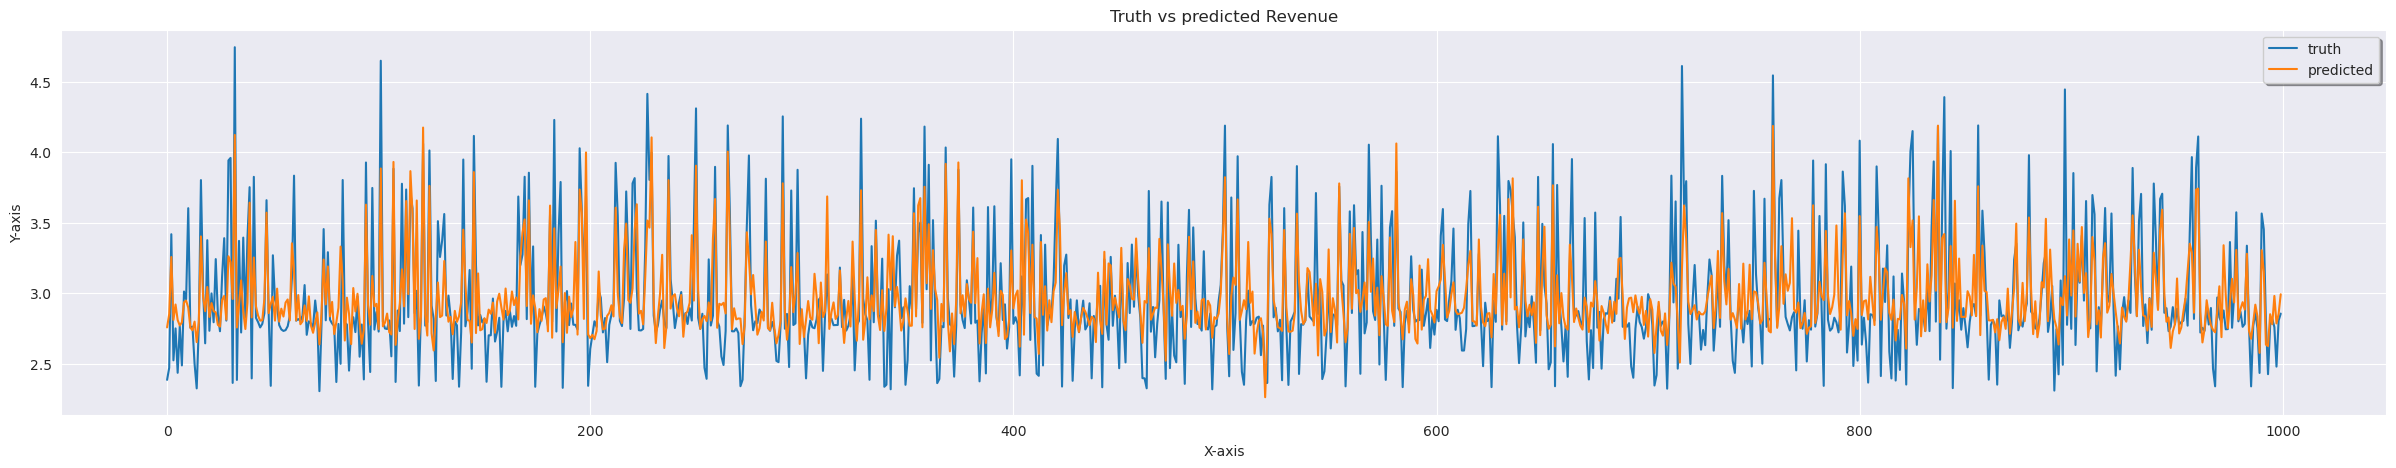

In [68]:
x_ax = range(len(y_test))
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.plot(x_ax, y_test, label="truth")
plt.plot(x_ax, y_predict, label="predicted")
plt.title("Truth vs predicted Revenue")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()

In [69]:
y_pred_non_log = 10**(y_predict) 
y_test_non_log = 10**(y_test)

In [70]:
from sklearn.metrics import mean_squared_log_error
rmsle = mean_squared_log_error(y_test_non_log,y_pred_non_log)**0.5
rmsle                                  

0.6532711586354677

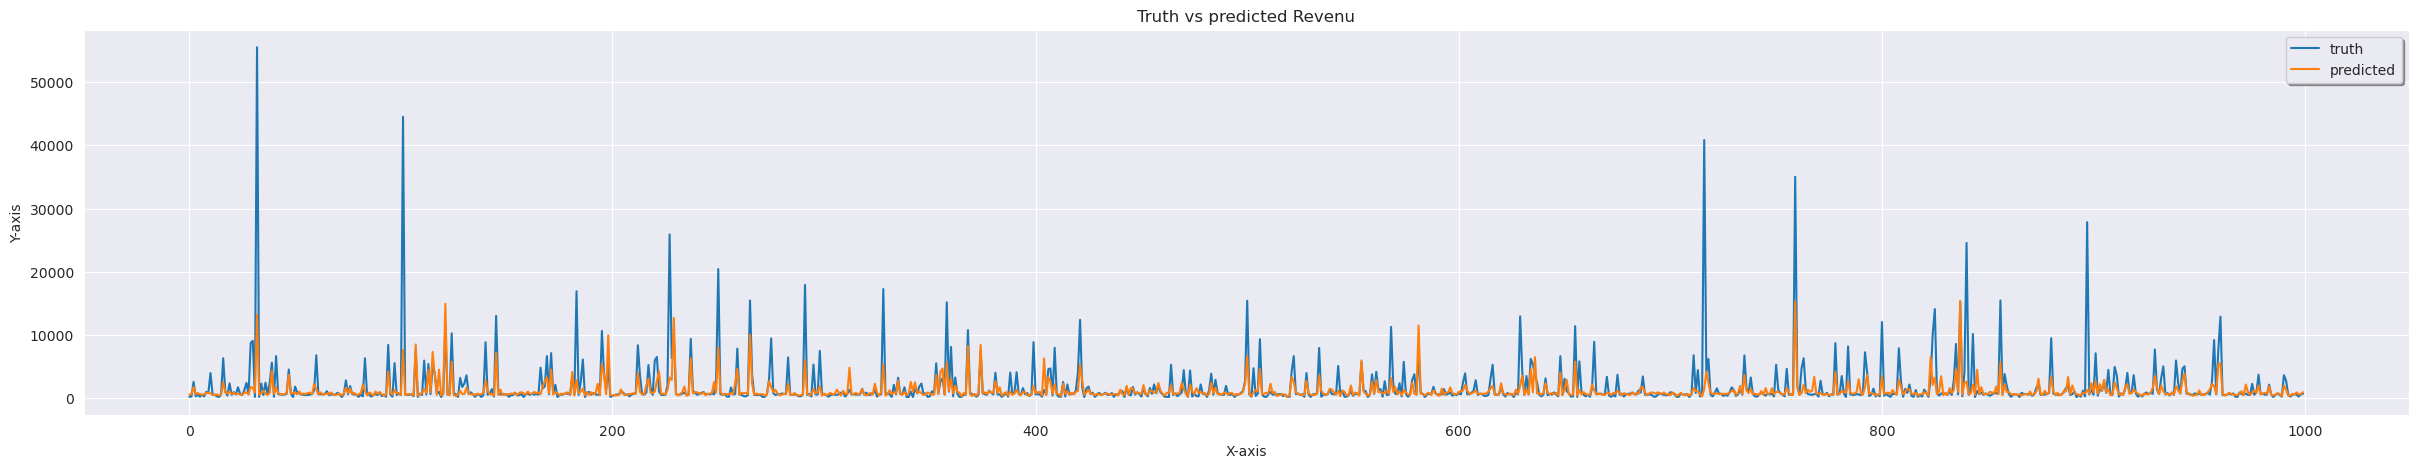

In [71]:
x_ax = range(len(y_test_non_log))
f = plt.figure()
f.set_figwidth(30)
f.set_figheight(5)
plt.plot(x_ax, y_test_non_log, label="truth")
plt.plot(x_ax, y_pred_non_log, label="predicted")
plt.title("Truth vs predicted Revenu")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
plt.show()